# Train Station Calculator

This file is the work to do the task: find the fastest route to go to STATION A to STATION B in France.

Librairies used:
- pandas (read csv)
- matplotlib (graphs)
- networkx (network graphs)
- unicodecode (remove accents)

## DATA

we are using the offical sncf tgv GTFS data.
Our goal is to create a dataset like our timetables.

In [164]:
# Let's load the new data for TGV
import pandas as pd

tgv_trips_df = pd.read_csv('./dataset/export_gtfs_voyages/trips.txt', delimiter=',')
tgv_stop_times_df = pd.read_csv('./dataset/export_gtfs_voyages/stop_times.txt', delimiter=',')
tgv_stops_df = pd.read_csv('./dataset/export_gtfs_voyages/stops.txt', delimiter=',')

tgv_trips_df.head(), tgv_stop_times_df.head(), tgv_stops_df.head()

(                                         route_id  service_id  \
 0  FR:Line::A74B127A-8882-4043-BAAA-F49A6703DE54:           1   
 1  FR:Line::A74B127A-8882-4043-BAAA-F49A6703DE54:           2   
 2  FR:Line::A74B127A-8882-4043-BAAA-F49A6703DE54:           3   
 3  FR:Line::9684FBBE-75D8-461A-B8F4-44181F11CFBC:           4   
 4  FR:Line::2881AC3D-A347-4440-BEF8-23ACAB159588:           5   
 
                                    trip_id  trip_headsign  direction_id  \
 0  OCESN12213F1304079:2023-08-29T11:49:37Z          12213           NaN   
 1  OCESN12213F2323578:2023-10-09T00:43:50Z          12213           NaN   
 2  OCESN12213F2410837:2023-10-10T00:42:10Z          12213           NaN   
 3  OCESN12244F2546867:2023-10-13T00:46:55Z          12244           NaN   
 4  OCESN12246F1317210:2023-08-29T11:49:37Z          12246           NaN   
 
    block_id  shape_id  
 0         1       NaN  
 1         2       NaN  
 2         3       NaN  
 3         4       NaN  
 4         5       

trip_id in the "trips.txt"

stop times and stop ids in "stop_times.txt"

the mapping of stop ids to station names in "stops.txt"

In [167]:
# We need to adjust our time parsing to handle times that exceed 24:00:00 for services passing midnight
def calculate_duration_adjusted(start_time, end_time):
    # Convert the time strings into datetime objects
    # We won't convert it to datetime directly because of the 24:00:00+ issue
    # Instead, we'll calculate the time delta in minutes directly
    start_hour, start_minute, start_second = map(int, start_time.split(':'))
    end_hour, end_minute, end_second = map(int, end_time.split(':'))
    # Calculate the total minutes for start and end times
    start_total_minutes = start_hour * 60 + start_minute + start_second / 60
    end_total_minutes = end_hour * 60 + end_minute + end_second / 60
    # Calculate the duration
    duration = end_total_minutes - start_total_minutes
    return duration


# Group the TGV stop_times DataFrame by trip_id
tgv_grouped = tgv_stop_times_df.groupby('trip_id')

# Create lists to hold the output data
tgv_trip_ids = []
tgv_durations = []
tgv_start_stations = []
tgv_end_stations = []

# Process each group with the adjusted duration calculation
for name, group in tgv_grouped:
    if not group.empty and not group['arrival_time'].isnull().all() and not group['departure_time'].isnull().all():
        sorted_group = group.sort_values(by='stop_sequence')
        start_time = sorted_group.iloc[0]['arrival_time']
        end_time = sorted_group.iloc[-1]['departure_time']
        start_station = sorted_group.iloc[0]['stop_id']
        end_station = sorted_group.iloc[-1]['stop_id']
        duration = calculate_duration_adjusted(start_time, end_time)
        tgv_trip_ids.append(name)
        tgv_durations.append(duration)
        tgv_start_stations.append(start_station)
        tgv_end_stations.append(end_station)

# Create a DataFrame from the output lists
tgv_trips_duration_df = pd.DataFrame({
    'trip_id': tgv_trip_ids,
    'duration': tgv_durations,
    'start_station_id': tgv_start_stations,
    'end_station_id': tgv_end_stations
})

# Map the start and end station IDs to names using the new stops data
tgv_stop_id_to_name_mapping = pd.Series(tgv_stops_df.stop_name.values, index=tgv_stops_df.stop_id).to_dict()
tgv_trips_duration_df['start_station'] = tgv_trips_duration_df['start_station_id'].map(tgv_stop_id_to_name_mapping)
tgv_trips_duration_df['end_station'] = tgv_trips_duration_df['end_station_id'].map(tgv_stop_id_to_name_mapping)

# Keep only relevant columns for the final CSV
tgv_final_df = tgv_trips_duration_df[['trip_id', 'duration', 'start_station', 'end_station']]

# Show the first few rows of the final DataFrame
tgv_final_df

,trip_id,duration,start_station,end_station
0,OCESN12213F1304079:2023-08-29T11:49:37Z,129.0,Paris Montparnasse Hall 1 - 2,Bordeaux Saint-Jean
1,OCESN12213F2323578:2023-10-09T00:43:50Z,266.0,Paris Montparnasse Hall 1 - 2,Toulouse Matabiau
2,OCESN12213F2410837:2023-10-10T00:42:10Z,129.0,Paris Montparnasse Hall 1 - 2,Bordeaux Saint-Jean
3,OCESN12244F2546867:2023-10-13T00:46:55Z,132.0,Bordeaux Saint-Jean,Paris Montparnasse Hall 1 - 2
4,OCESN12246F1317210:2023-08-29T11:49:37Z,128.0,Bordeaux Saint-Jean,Paris Montparnasse Hall 1 - 2
...,...,...,...,...
4862,OCESN9898F2227771:2023-08-29T11:49:37Z,466.0,Montpellier Saint-Roch,Luxembourg
4863,OCESN9898F2356811:2023-10-09T00:43:50Z,469.0,Montpellier Saint-Roch,Luxembourg
4864,OCESN9898F2387489:2023-10-06T00:53:43Z,415.0,Montpellier Saint-Roch,Metz
4865,OCESN9898F2387789:2023-08-29T11:49:37Z,466.0,Montpellier Saint-Roch,Luxembourg


In [168]:
# remove duplicates
tgv_final_df = tgv_final_df.drop_duplicates(subset=["start_station", "end_station"], keep='first')
tgv_final_df

,trip_id,duration,start_station,end_station
0,OCESN12213F1304079:2023-08-29T11:49:37Z,129.0,Paris Montparnasse Hall 1 - 2,Bordeaux Saint-Jean
1,OCESN12213F2323578:2023-10-09T00:43:50Z,266.0,Paris Montparnasse Hall 1 - 2,Toulouse Matabiau
3,OCESN12244F2546867:2023-10-13T00:46:55Z,132.0,Bordeaux Saint-Jean,Paris Montparnasse Hall 1 - 2
77,OCESN12289F2203976:2023-09-05T00:35:10Z,94.0,Paris Montparnasse Hall 1 - 2,Poitiers
82,OCESN2050F2243940:2023-10-13T00:46:55Z,131.0,Strasbourg,Paris Est
...,...,...,...,...
4823,OCESN9890F1993704:2023-10-13T00:46:55Z,222.0,Strasbourg,Bruxelles Midi
4846,OCESN9896F2175115:2023-08-29T11:49:37Z,473.0,Marseille Saint-Charles,Luxembourg
4848,OCESN9896F2240179:2023-10-09T00:43:50Z,426.0,Marseille Saint-Charles,Metz
4852,OCESN9896F2411725:2023-10-09T00:43:50Z,461.0,Aix-en-Provence TGV,Luxembourg


In [131]:
# export the final tgv dataframe
tgv_final_df.to_csv("./dataset/export_gtfs_voyages/tgv_timetables.csv", index=False, encoding="utf-8")

## Create the Network Graph with Network X

Our goal is to find the fastest path to go to a destination A to a destination B. This problem is equals to a force directed graph.

**NetworkX** is a library for studying graphs and networks. We can use it to build our graph based on our dataset.

https://networkx.org/


In [229]:
import pandas as pd

timetables_df = pd.read_csv("./dataset/export_gtfs_voyages/tgv_timetables.csv", encoding="utf-8")
# lower case stations
timetables_df[["start_station", "end_station"]] = timetables_df[["start_station", "end_station"]].applymap(str.lower)
timetables_df

,trip_id,duration,start_station,end_station
0,OCESN12213F1304079:2023-08-29T11:49:37Z,129.0,paris montparnasse hall 1 - 2,bordeaux saint-jean
1,OCESN12213F2323578:2023-10-09T00:43:50Z,266.0,paris montparnasse hall 1 - 2,toulouse matabiau
2,OCESN12244F2546867:2023-10-13T00:46:55Z,132.0,bordeaux saint-jean,paris montparnasse hall 1 - 2
3,OCESN12289F2203976:2023-09-05T00:35:10Z,94.0,paris montparnasse hall 1 - 2,poitiers
4,OCESN2050F2243940:2023-10-13T00:46:55Z,131.0,strasbourg,paris est
...,...,...,...,...
291,OCESN9890F1993704:2023-10-13T00:46:55Z,222.0,strasbourg,bruxelles midi
292,OCESN9896F2175115:2023-08-29T11:49:37Z,473.0,marseille saint-charles,luxembourg
293,OCESN9896F2240179:2023-10-09T00:43:50Z,426.0,marseille saint-charles,metz
294,OCESN9896F2411725:2023-10-09T00:43:50Z,461.0,aix-en-provence tgv,luxembourg


In [230]:
import matplotlib.pyplot as plt
import networkx as nx

# create the network directed graph from the dataset
G = nx.from_pandas_edgelist(timetables_df,
                            source="start_station",
                            target="end_station",
                            edge_attr='duration', # weights
                            create_using=nx.DiGraph(oriented=True, data=True))

### Visualizing

We can visualize our graph with the library **matplotlib**



There are different layout to visualize a graph. Each with it's own structure:

https://networkx.org/documentation/stable/reference/drawing.html

**Circular** Layout (nx.draw_circular):
    Good for showing cyclic processes or circular relationships.
    Can be hard to interpret if there are many nodes and edges.

**Kamada-Kawai** Layout (nx.kamada_kawai_layout):
    Good for general-purpose display of graphs.
    Positions nodes in a way that reduces edge crossings and edge length.

**Spring** Layout (nx.draw_spring or nx.spring_layout):
    Good for visual clarity, as it spaces nodes evenly to reduce overlaps and crossings.
    Uses a force-directed algorithm to position nodes.

**Shell** Layout (nx.draw_shell or nx.shell_layout):
    Allows grouping of nodes into concentric circles.
    Good for showing hierarchical or grouped relationships.

**Random** Layout (nx.draw_random or nx.random_layout):
    Nodes are positioned randomly, it may not provide meaningful visualization but can be useful for certain types of analysis or datasets.

**Spectral** Layout (nx.draw_spectral or nx.spectral_layout):
    Good for showing clusters or communities of nodes.
    Uses the eigenvalues of the graph Laplacian to position nodes.

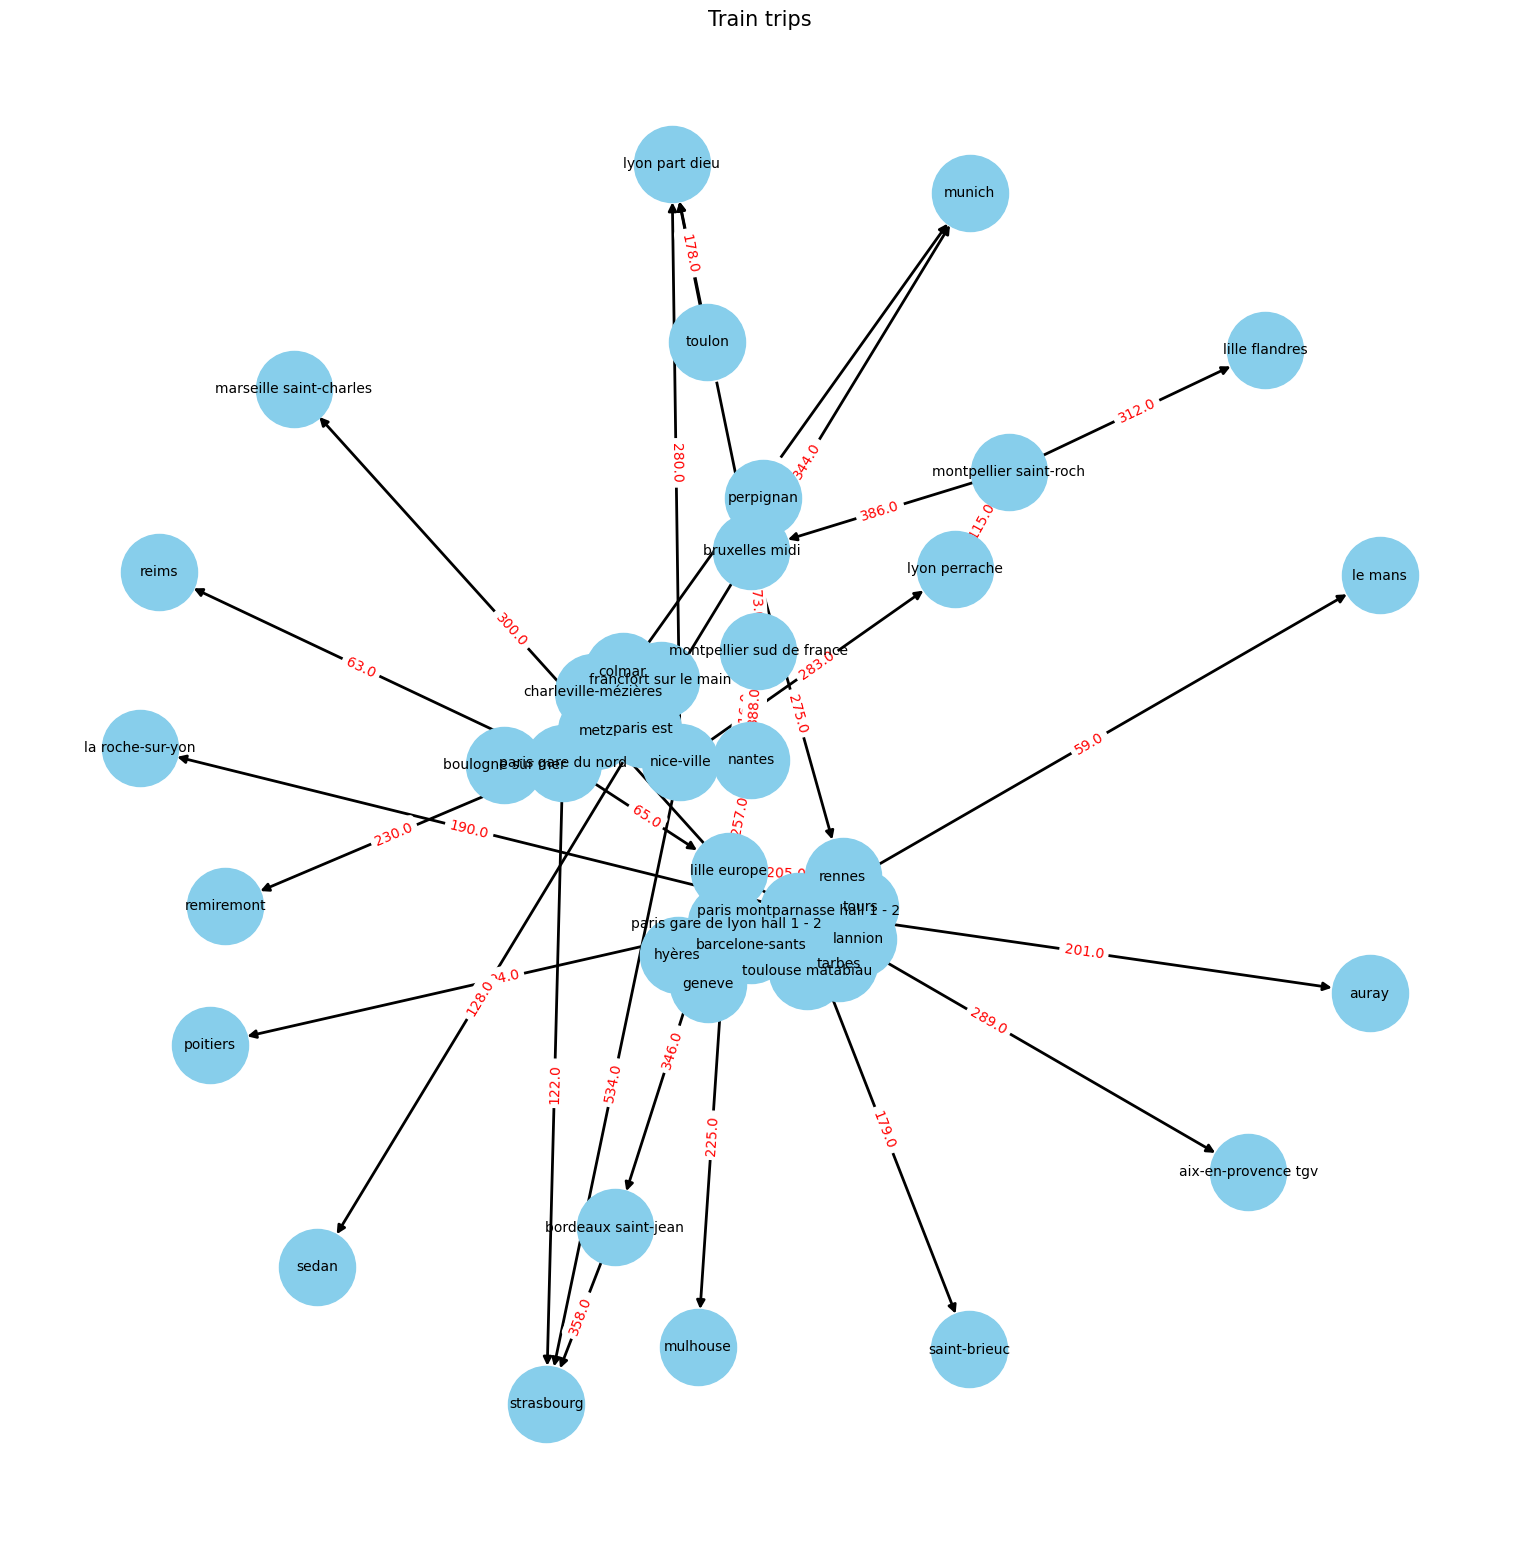

In [300]:
import matplotlib.pyplot as plt
import networkx as nx

# Get 50 Stations
df_sample = timetables_df.sample(n=50)

# Create the directed graph
G_test = nx.from_pandas_edgelist(df_sample,
                                source="start_station", 
                                target="end_station",
                                edge_attr='duration', # weights
                                create_using=nx.DiGraph(oriented=True, data=True))

# Create the graph
plt.figure(figsize=(15,15))

# Draw the nodes and edges
# best: kamada_kawai / spring
pos = nx.spring_layout(G_test)  # Get positions for all nodes
nx.draw(G_test, pos,
        with_labels=True,
        node_size=3000,
        node_color="skyblue",
        width=2,
        font_size=10,
        arrowsize=12,

        arrowstyle="-|>")

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G_test, 'duration')
nx.draw_networkx_edge_labels(G_test, pos, edge_labels=edge_labels, font_color='red')

# Display
plt.title('Train trips', size=15)
plt.show()

### Find the fastest path

**NetworkX** graphs can apply **algorithms** (the most known is **Dijkstra**) to find the fastest route between a start node and a end node.

Here is the list of algorithms that integrates NetworkX: 
https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html

In [232]:
timetables_df.head()

,trip_id,duration,start_station,end_station
0,OCESN12213F1304079:2023-08-29T11:49:37Z,129.0,paris montparnasse hall 1 - 2,bordeaux saint-jean
1,OCESN12213F2323578:2023-10-09T00:43:50Z,266.0,paris montparnasse hall 1 - 2,toulouse matabiau
2,OCESN12244F2546867:2023-10-13T00:46:55Z,132.0,bordeaux saint-jean,paris montparnasse hall 1 - 2
3,OCESN12289F2203976:2023-09-05T00:35:10Z,94.0,paris montparnasse hall 1 - 2,poitiers
4,OCESN2050F2243940:2023-10-13T00:46:55Z,131.0,strasbourg,paris est


In [233]:
# get two random stations
import random

start_stations = list(timetables_df["start_station"].unique())
end_stations = list(timetables_df["end_station"].unique()) # end stations aren't the same

start_station = random.choice(start_stations)
end_station = random.choice(end_stations)

print(start_station, end_station)

lausanne la rochelle


In [234]:
def random_stations() -> tuple[str, str]:
    """
    Find 2 stations that has a path
    """
    start_stations = list(timetables_df["start_station"].unique())
    end_stations = list(timetables_df["end_station"].unique()) # end stations aren't the same
    while(True):
        start_station = random.choice(start_stations)
        end_station = random.choice(end_stations)
        has_path = nx.has_path(G, source=start_station, target=end_station)
        if(has_path):
            return start_station, end_station

def get_path_weight(graph, path, weight):
    return sum(graph.edges[path[i], path[i + 1]][weight] for i in range(len(path) - 1))

In [235]:
# get 2 stations
start_station, end_station = random_stations()
start_station, end_station

('poitiers', 'grenoble')

In [236]:
# Get all simple paths in the graph
all_paths = list(nx.all_simple_paths(G, source=start_station, target=end_station, cutoff=5))

# Get the weights of all paths
all_path_weights = [get_path_weight(G, path, 'duration') for path in all_paths]

# Print paths with their weights
for path, weight in zip(all_paths, all_path_weights):
    print(f"Path: {path}, Duration: {weight}")

Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'toulouse matabiau', 'lyon perrache', 'paris gare de lyon hall 1 - 2', 'grenoble'], Duration: 1008.0
Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'toulouse matabiau', 'lyon part dieu', 'paris gare de lyon hall 1 - 2', 'grenoble'], Duration: 980.0
Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'nantes', 'montpellier sud de france', 'paris gare de lyon hall 1 - 2', 'grenoble'], Duration: 1071.0
Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'nantes', 'lyon perrache', 'paris gare de lyon hall 1 - 2', 'grenoble'], Duration: 937.0
Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'nantes', 'marseille saint-charles', 'paris gare de lyon hall 1 - 2', 'grenoble'], Duration: 1086.0
Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'nantes', 'lyon part dieu', 'paris gare de lyon hall 1 - 2', 'grenoble'], Duration: 890.0
Path: ['poitiers', 'paris montparnasse hall 1 - 2', 'rennes', 'marseille saint-charles', 'paris gare de l

In [237]:
# Get the shortest path with the dijkstra algorithm
shortest_path = nx.dijkstra_path(G, source=start_station, target=end_station, weight="duration")

# Get the weight of the shortest path
shortest_path_weight = get_path_weight(G, shortest_path, 'duration')

print(f"Shortest path: {shortest_path}")
print(f"Duration of shortest path: {shortest_path_weight}")

Shortest path: ['poitiers', 'paris montparnasse hall 1 - 2', 'rennes', 'lyon part dieu', 'paris gare de lyon hall 1 - 2', 'grenoble']
Duration of shortest path: 820.0


### Find the better pathfinding algorithm


In jupyter notebooks, you can time your code with these magics comands:
- %time function(): one line time
- %%time: multiple line
- %%timeit: multiple time test (average)

In [238]:
# Get 10 randoms journeys 
stations = [random_stations() for _ in range(10)]
start_stations, end_stations = zip(*stations)

# Convert tuples to lists
start_stations = list(start_stations)
end_stations = list(end_stations)

print(stations)
print(start_stations)
print(end_stations)

[('vannes', 'dijon'), ('lorient', 'basel sbb'), ('stuttgart hbf', 'montpellier saint-roch'), ('nice-ville', 'le croisic'), ('rang-du-fliers - verton - berck', 'saint-brieuc'), ('nice-ville', 'charleville-mézières'), ('mulhouse', 'tours'), ('toulouse matabiau', 'besançon viotte'), ('nancy place de la république', 'chambéry - challes-les-eaux'), ('nancy place de la république', 'strasbourg')]
['vannes', 'lorient', 'stuttgart hbf', 'nice-ville', 'rang-du-fliers - verton - berck', 'nice-ville', 'mulhouse', 'toulouse matabiau', 'nancy place de la république', 'nancy place de la république']
['dijon', 'basel sbb', 'montpellier saint-roch', 'le croisic', 'saint-brieuc', 'charleville-mézières', 'tours', 'besançon viotte', 'chambéry - challes-les-eaux', 'strasbourg']


In [239]:
# Preload all shortest paths
shortest_paths = {}
for start in start_stations:
    for end in end_stations:
        if start != end:
            if(nx.has_path(G, source=start, target=end)):
                shortest_paths[(start, end)] = nx.shortest_path(G, source=start, target=end, weight="duree")

In [240]:
shortest_paths

{('vannes', 'dijon'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'nantes',
  'marseille saint-charles',
  'paris gare de lyon hall 1 - 2',
  'dijon'],
 ('vannes', 'basel sbb'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'nantes',
  'marseille saint-charles',
  'paris gare de lyon hall 1 - 2',
  'basel sbb'],
 ('vannes', 'montpellier saint-roch'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'bordeaux saint-jean',
  'strasbourg',
  'montpellier saint-roch'],
 ('vannes', 'le croisic'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'le croisic'],
 ('vannes', 'saint-brieuc'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'saint-brieuc'],
 ('vannes', 'charleville-mézières'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'bordeaux saint-jean',
  'strasbourg',
  'paris est',
  'charleville-mézières'],
 ('vannes', 'tours'): ['vannes', 'paris montparnasse hall 1 - 2', 'tours'],
 ('vannes', 'besançon viotte'): ['vannes',
  'paris montparnasse hall 1 - 2',
  'nantes',
  'marsei

In [241]:
# Johnson's algorithm to find all pairs shortest paths
shortest_paths_johnson = nx.johnson(G, weight="duration")
shortest_paths_johnson

{'paris montparnasse hall 1 - 2': {'paris montparnasse hall 1 - 2': ['paris montparnasse hall 1 - 2'],
  'bordeaux saint-jean': ['paris montparnasse hall 1 - 2',
   'bordeaux saint-jean'],
  'toulouse matabiau': ['paris montparnasse hall 1 - 2', 'toulouse matabiau'],
  'poitiers': ['paris montparnasse hall 1 - 2', 'poitiers'],
  'brest': ['paris montparnasse hall 1 - 2', 'brest'],
  'quimper': ['paris montparnasse hall 1 - 2', 'quimper'],
  'auray': ['paris montparnasse hall 1 - 2', 'auray'],
  'nantes': ['paris montparnasse hall 1 - 2', 'nantes'],
  'niort': ['paris montparnasse hall 1 - 2', 'niort'],
  'la rochelle': ['paris montparnasse hall 1 - 2', 'la rochelle'],
  'rennes': ['paris montparnasse hall 1 - 2', 'rennes'],
  'saint-malo': ['paris montparnasse hall 1 - 2', 'saint-malo'],
  'lorient': ['paris montparnasse hall 1 - 2', 'lorient'],
  'tours': ['paris montparnasse hall 1 - 2', 'tours'],
  'arcachon': ['paris montparnasse hall 1 - 2', 'arcachon'],
  'hendaye': ['paris montp

In [243]:
shortest_paths_johnson["bordeaux saint-jean"]

{'bordeaux saint-jean': ['bordeaux saint-jean'],
 'paris montparnasse hall 1 - 2': ['bordeaux saint-jean',
  'paris montparnasse hall 1 - 2'],
 'strasbourg': ['bordeaux saint-jean', 'strasbourg'],
 'aéroport charles de gaulle 2 tgv': ['bordeaux saint-jean',
  'aéroport charles de gaulle 2 tgv'],
 'lille flandres': ['bordeaux saint-jean', 'lille flandres'],
 'lille europe': ['bordeaux saint-jean', 'lille europe'],
 'tourcoing': ['bordeaux saint-jean', 'tourcoing'],
 'freiburg (breisgau) hbf': ['bordeaux saint-jean', 'freiburg (breisgau) hbf'],
 'toulouse matabiau': ['bordeaux saint-jean',
  'paris montparnasse hall 1 - 2',
  'toulouse matabiau'],
 'poitiers': ['bordeaux saint-jean',
  'paris montparnasse hall 1 - 2',
  'poitiers'],
 'brest': ['bordeaux saint-jean', 'paris montparnasse hall 1 - 2', 'brest'],
 'quimper': ['bordeaux saint-jean',
  'paris montparnasse hall 1 - 2',
  'quimper'],
 'auray': ['bordeaux saint-jean', 'paris montparnasse hall 1 - 2', 'auray'],
 'nantes': ['bordeau

Pathfinding

dijkstra: Only works with non negative weights

bellman: slower than dijkstra, but works with negative weights

In [244]:
# test functions
def test_dijkstra(graph, pairs):
    return [nx.dijkstra_path(graph, source=start, target=end) for start, end in pairs]

def test_dijkstra_bidirectionnal(graph, pairs):
     return [nx.bidirectional_dijkstra(graph, source=start, target=end) for start, end in pairs]

def test_bellman_ford(graph, pairs):
    return [nx.bellman_ford_path(graph, source=start, target=end) for start, end in pairs]

def test_dictionary_indexing(pairs, paths):
    return [paths[(start, end)] for start, end in pairs]

def test_dictionary_indexing_johnson(pairs, paths):
    return [paths[start][end] for start, end in pairs]




if __name__ == "__main__":
    import timeit

    num_runs = 10000
    
    # Assume pairs of start and end stations are stored in a list of tuples
    pairs = stations

    # Timing the functions using timeit
    print("Dijkstra Time:", timeit.timeit(lambda: test_dijkstra(G, pairs), number=num_runs) / num_runs)
    print("Dijkstra Bidirectionnal Time:", timeit.timeit(lambda: test_bellman_ford(G, pairs), number=num_runs) / num_runs)

    print("Bellman Ford Time:", timeit.timeit(lambda: test_bellman_ford(G, pairs), number=num_runs) / num_runs)
    
    print("Dictionnary indexing Time:", timeit.timeit(lambda: test_dictionary_indexing(pairs, shortest_paths), number=num_runs) / num_runs)  # shortest_paths is a dictionary containing the paths
    print("Dictionnary Jonhson indexing Time:", timeit.timeit(lambda: test_dictionary_indexing_johnson(pairs, shortest_paths_johnson), number=num_runs) / num_runs)  # shortest_paths_johnson is a dictionary containing the paths


Dijkstra Time: 0.0012705185700000584
Dijkstra Bidirectionnal Time: 0.002004170040000099
Bellman Ford Time: 0.001994785349999802
Dictionnary indexing Time: 1.0857700002816273e-06
Dictionnary Jonhson indexing Time: 8.25529999929131e-07


In our case, with a **directed**, **weighted graph** without bi-directional or negative weights, **Dijkstra**'s algorithm is optimal for real-time shortest path calculations. However, for preloading all shortest paths, **Johnson**’s algorithm is more efficient, especially with smaller, static datasets. Dijkstra excels for real-time calculations in dynamic or larger datasets, while Johnson is ideal when paths can be preloaded for quicker retrieval.


## Production startup

This is the parts, the functions, utilities we will use in production

- For the algorithm we chose to preload with **Johnson** Algorithm.

In [3]:
# Loading DATASETS
from unidecode import unidecode
import pandas as pd
import re

# CITIES
cities_df = pd.read_csv("./dataset/cities.csv", delimiter=",", encoding="utf-8")

# STATIONS
stations_df = pd.read_csv("./dataset/liste-des-gares.csv", delimiter=";", encoding="utf-8")
stations_df["commune"] = stations_df["commune"].str.lower() # lowercase
stations_df["commune"] = stations_df["commune"].str.replace("-", " ") # remove dash
stations_df["commune"] = stations_df["commune"].apply(unidecode) # remove accent

def reformat_cities(commune):
    match = re.search(r'\((.*?)\)', commune)
    if match:
        determinant = match.group(1)
        commune = re.sub(r'\(.*?\)\s*', '', commune).strip()
        return f"{determinant} {commune}"
    return commune

stations_df['commune'] = stations_df['commune'].apply(reformat_cities) # remove brackets (havre (le ) -> le havre)
stations_df['commune'] = stations_df['commune'].str.replace(' +', ' ') # remove whitespaces

# TIMETABLES
timetables_df = pd.read_csv("./dataset/export_gtfs_voyages/tgv_timetables.csv", encoding="utf-8")
timetables_df[["start_station", "end_station"]] = timetables_df[["start_station", "end_station"]].applymap(str.lower) # lower case stations

C:\Users\loannmr\AppData\Local\Temp\ipykernel_19444\1580638477.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  timetables_df[["start_station", "end_station"]] = timetables_df[["start_station", "end_station"]].applymap(str.lower) # lower case stations


In [6]:
# save the timetables
timetables_df.to_csv('timetables.csv', sep=',', index=False)

In [298]:
# GRAPH UTILITIES
import pandas as pd
import networkx as nx

def create_graph(df):
    G = nx.from_pandas_edgelist(timetables_df,
                            source="start_station", 
                            target="end_station",
                            edge_attr='duration', # weights
                            create_using=nx.DiGraph(oriented=True, data=True))
    return G

def preload_fastest_paths(G):
    """
    Example: access the shortest path and its weight from node A to node B
    path_from_A_to_B = weighted_paths['A']['B']['path']
    weight_from_A_to_B = weighted_paths['A']['B']['duration']
    """
    # Johnson's algorithm to find all pairs shortest paths
    shortest_paths_johnson = nx.johnson(G, weight="duration")
    # Create a dictionary to store the paths with their weights
    weighted_paths = {}
    for source, targets in shortest_paths_johnson.items():
        weighted_paths[source] = {}
        for target, path in targets.items():
            weight = sum(G[path[i]][path[i + 1]]['duration'] for i in range(len(path) - 1))
            weighted_paths[source][target] = {'path': path, 'duration': weight}
    return weighted_paths

def find_fastest_paths(start_stations, end_stations):
    best_path = None
    shortest_duration = float('inf')
    all_paths_info = []

    for start in start_stations:
        for end in end_stations:
            if start in shortest_paths and end in shortest_paths[start]:
                duration = shortest_paths[start][end]['duration']
                
                path_info = {
                    "start": start,
                    "end": end,
                    "duration": duration,
                    "path": shortest_paths[start][end]['path']
                }
                
                all_paths_info.append(path_info)
                
                if duration < shortest_duration:
                    shortest_duration = duration
                    best_path = (start, end, duration)
    return best_path, all_paths_info

# Create graph and preload paths
G = create_graph(timetables_df)
shortest_paths = preload_fastest_paths(G)

In [297]:
shortest_paths['paris montparnasse hall 1 - 2']["paris montparnasse hall 1 - 2"]

{'path': ['paris montparnasse hall 1 - 2'], 'duration': 0}

In [284]:
# DATASET UTILITIES
def get_city(name) -> pd.DataFrame:
    return cities_df[cities_df["label"] == name].iloc[0]


def get_stations(city: str) -> pd.DataFrame:
    """Returns train stations of the city"""
    return stations_df[stations_df["commune"] == str.lower(city)]

def filter_timetable_by_city(city: str, is_destination: bool = False) -> pd.DataFrame:
    """
    Filter the timetable based on a city name for either starture or destination.
    
    Parameters:
    - timetables_df (pd.DataFrame): DataFrame containing the timetable data.
    - city (str): Name of the city to filter by.
    - is_destination (bool): If True, filters by destination (end_station). 
                             If False, filters by starture (start_station). Default is False.

    Returns:
    - pd.DataFrame: Filtered timetable DataFrame.
    """
    column = "end_station" if is_destination else "start_station"
    return timetables_df[timetables_df[column].str.startswith(str.lower(city))]

In [291]:
# test get_stations
import random

# Test filter city
grandes_villes = [
    "Paris", 
    "Marseille", 
    "Lyon", 
    "Toulouse", 
    "Nice", 
    "Nantes", 
    "Strasbourg", 
    "Montpellier", 
    "Bordeaux", 
    "Lille", 
    "Rennes", 
    "Reims", 
    "Saint-Étienne", 
    "Toulon", 
    "Le Havre", 
    "Grenoble", 
    "Dijon", 
    "Angers", 
    "Nimes", 
    "Villeurbanne"
]
city = random.choice(grandes_villes)

print(city)
print(get_stations(city))

Grenoble
      code_uic   libelle fret voyageurs  code_ligne  rg_troncon       pk  \
353   87747006  Grenoble    O         O      905000           1  130+538   
1763  87747006  Grenoble    O         O      909000           1  000-142   

       commune departemen  idreseau                                idgaia  \
353   grenoble      ISERE      4362  d9b7c8fc-6667-11e3-89ff-01f464e0362d   
1763  grenoble      ISERE      4362  d9b7c8fc-6667-11e3-89ff-01f464e0362d   

            x_l93         y_l93   x_wgs84   y_wgs84  \
353   913131.6496  6.458277e+06  5.714517  45.19083   
1763  913478.8083  6.457320e+06  5.718515  45.18211   

                                     c_geo  \
353   45.19083025228243,5.7145168198585345   
1763  45.182109650519095,5.718515336422927   

                              geo_point_2d  \
353   45.190830251320165,5.714516819858535   
1763   45.18210964955681,5.718515336422927   

                                              geo_shape  
353   {"coordinates": [5.714

In [292]:
import random

city = random.choice(grandes_villes)

print(city)
filter_timetable_by_city(city, is_destination=False)

Strasbourg


,trip_id,duration,start_station,end_station
4,OCESN2050F2243940:2023-10-13T00:46:55Z,131.0,strasbourg,paris est
5,OCESN2050F2470133:2023-10-13T00:46:55Z,135.0,strasbourg,paris gare du nord
8,OCESN2087F2239944:2023-08-29T11:49:37Z,346.0,strasbourg,aix-en-provence tgv
9,OCESN2087F2308903:2023-10-11T00:54:01Z,363.0,strasbourg,marseille saint-charles
10,OCESN2090F2441881:2023-10-09T00:43:50Z,363.0,strasbourg,bordeaux saint-jean
14,OCESN2203F2174017:2023-08-29T11:49:37Z,371.0,strasbourg,montpellier saint-roch
23,OCESN2239F2173963:2023-10-04T00:41:06Z,535.0,strasbourg,nice-ville
24,OCESN2239F2346865:2023-10-09T00:43:50Z,423.0,strasbourg,toulon
100,OCESN5470F1306365:2023-10-04T09:03:30Z,286.0,strasbourg,rennes
102,OCESN5486F2206999:2023-10-09T00:43:50Z,348.0,strasbourg,nantes


In [302]:
start_stations = ['lyon part dieu', 'lyon perrache']
end_stations = ['paris montparnasse hall 1 - 2', 'paris est', 'paris gare du nord', 'paris gare de lyon hall 1 - 2']

%timeit best_path, all_paths = find_fastest_paths(start_stations, end_stations)

print("Paths: ", all_paths)
print("Best path: ", best_path)

3.53 µs ± 72.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Paths:  [{'start': 'lyon part dieu', 'end': 'paris montparnasse hall 1 - 2', 'duration': 327.0, 'path': ['lyon part dieu', 'rennes', 'paris montparnasse hall 1 - 2']}, {'start': 'lyon part dieu', 'end': 'paris est', 'duration': 349.0, 'path': ['lyon part dieu', 'lille europe', 'paris gare du nord', 'reims', 'paris est']}, {'start': 'lyon part dieu', 'end': 'paris gare du nord', 'duration': 234.0, 'path': ['lyon part dieu', 'lille europe', 'paris gare du nord']}, {'start': 'lyon part dieu', 'end': 'paris gare de lyon hall 1 - 2', 'duration': 116.0, 'path': ['lyon part dieu', 'paris gare de lyon hall 1 - 2']}, {'start': 'lyon perrache', 'end': 'paris montparnasse hall 1 - 2', 'duration': 330.0, 'path': ['lyon perrache', 'rennes', 'paris montparnasse hall 1 - 2']}, {'start': 'lyon perrache', 'end': 'paris est', 'duration': 354.0, 'path': ['lyon perrache', 'strasbourg', 'paris est']}, {'start': 'lyon perrache', 'en